In [1]:
import os
import sys
path = '/'.join(os.path.abspath('').split('/')[0:-2])
print(path)
sys.path.append(path)

import pickle
import pandas as pd
import json
import random, tqdm
import numpy as np

from experts.ucb import ucb
from exploration.explore import explore
from exploration.outils import stats

import plotly.express as px

/home/mora/Documents/projects/Bandits


In [3]:
with open('../../../datasharing/tickers.json','r') as file:
    tickers = json.load(file)

tickers = tickers["sp500"]

In [4]:
# Load the pickle file that contains the full data for each stock
with open('../../../datasharing/hist_stock_data.pkl','rb') as file:
    df_hst_tickers = pickle.load(file)

# Chose the label "Close" as the main label to analyse the price series
label = 'Close'
df_close_stocks = pd.DataFrame([])
for key, df in df_hst_tickers.items():
    df_close_stocks = pd.concat([df_close_stocks,
                                 df[label]], axis = 1)

# Create a single data frame that cotains the series data from all the SP500 stocks
df_close_stocks.columns = list(df_hst_tickers.keys())
df_close_stocks['date'] = df_close_stocks.index
df_close_stocks.index = pd.to_datetime(df_close_stocks['date'])


df_close_stocks = pd.DataFrame()

for ticker in tickers:
    srs = df_hst_tickers[ticker][['Close']]
    srs.columns = [ticker]
    df_close_stocks = pd.concat([df_close_stocks,srs], axis = 1)
    
df_close_stocks.reset_index(inplace = True)
df_close_stocks['date'] = pd.to_datetime(df_close_stocks['Date'])

df_close_stocks.set_index('date', inplace = True)
df_2w = df_close_stocks.resample("2W").last()

/tmp/ipykernel_1406571/1425304769.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_close_stocks['date'] = df_close_stocks.index
/tmp/ipykernel_1406571/1425304769.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_close_stocks.reset_index(inplace = True)
/tmp/ipykernel_1406571/1425304769.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a d

In [5]:
# Creating the function that compute the statistics
def get_stats(df_close_stocks, tickers, years = None, inter = None, freq = 'M', min_els = 6):
    """
    This function produces some statistics using a dataframe fille with stocks.
    Precisely the average mean return and the sharpe ratio.
    Args:
        df_hst_tickers (dict) - contains dataframes for multiple stocks
        tickers (list) - the list of tickers to compute the statistics 
        years (list) - the list of years to compute the statistics
        inter (slice) - A slice that precises the data indexs to compute the statistics
        freq (str) - the frequency for the statistics (Y,M,W,2W, ...)
        min_els(int) - the minimum quantity of elements in the series required
            after the frequency postprocessing.
    """
    st_stats = {}
    for ticker in tickers:
        if years:
            tmp_df = df_close_stocks[df_close_stocks['Date'].dt.year.isin(years)]
        elif inter:
            tmp_df = df_close_stocks.iloc[inter]

        pc_m = tmp_df[ticker].pct_change(periods = 1, freq = freq).dropna()

        # discart ticket if not enough data
        if pc_m.shape[0] < min_els:
            continue
            
        av_ret = pc_m.mean()
        sr = av_ret / pc_m.std()
        st_stats[ticker] = {"sr":sr, 'av_ret':av_ret}
            
    return st_stats

def df_and_sort(st_stats, col):
    """
    Function that creates a dataframe using a dictionary with of stocks with statistics
    metrics and sort the dataframe based on the column name precised.
    Args:
        st_stats (dict) - The dictionary containing the statistics.
        col (str) - The name of the column for sorting.
    """
    df_stats = pd.DataFrame(st_stats).transpose()
    df_stats.sort_values(by=col, inplace = True, ascending = False)
    return df_stats


def create_stock_groups(lst_stocks: list, basket_size: int,
                        max_stocks: int):
    """
    Create multiple group of stocks with basket_size elements
    inside each group.
    Args:
        lst_stocks (list) : List of stocks
        basket_size (int): The total element of stocks in
            each basket.
    """
    
    random.shuffle(tst)
    stcks = {'stocks_dict':list(tst), 'groups':{}}

    for i in range(0,max_stocks,basket_size):
        stcks['groups'].update({i:list(tst[i:i+basket_size])})
    
    return stcks


def simulate_year(df_series, years: list, n_sims: int,
                  stock_groups: dict, exploration_rate: float,
                  p_c: float):

    df_test = df_series[df_series['Date'].dt.year.isin(years)]
    lines = []

    for group, lst_stocks in stock_groups['groups'].items():

        df_bandits = df_test[lst_stocks].pct_change(1).dropna()

        if df_bandits.shape[0] == 0:
            continue

        arguments = {"exploration_rate": exploration_rate,
                     "n_bandit":df_bandits.shape[1],
                     "steps":df_bandits.shape[0],
                     "c":p_c,
                     "df_bandits":df_bandits
                    }


        exp = explore(ucb.execute)
        exp.execute(n_sims, **arguments)
        mean, std = stats(exp.rets_compo)
        line = [arguments["c"],
                arguments["exploration_rate"],
                mean,
                std]

        lines.append(line)

    df_rets = pd.DataFrame(lines)
    df_rets.columns = ["c", "expl", "mean", "std"]
    
    return df_rets.mean()

In [13]:
max_stocks = 120
stock_groups = {}
basket_size = 5
metric = 'sr' # choose between 'av_ret' or 'sr'

for year in tqdm.tqdm(range(2013,2024)):

    years_tr = list(range(year - 10, year))
    stats_tr = get_stats(df_close_stocks, tickers, years = years_tr)
    df_stats_tr = df_and_sort(stats_tr, metric)
    tst = df_stats_tr.index[0:max_stocks].values
    stock_groups[year] = create_stock_groups(tickers,
                                             basket_size,
                                             max_stocks)

100%|███████████████████████████████████████████| 11/11 [00:43<00:00,  3.95s/it]


In [15]:
final_stats = []

for year in tqdm.tqdm(range(2013,2024)):
    for exploration_rate in np.arange(0.01,0.15,0.01):
        for p_c in np.arange(0.05,2.0,0.05):
            st_year = simulate_year(df_2w, [year], n_sims = 5,
                                    stock_groups = stock_groups[year],
                                    exploration_rate = exploration_rate,
                                    p_c = p_c
                                   )
            tmp_year = {"year":year,"ex_rate":exploration_rate,
                        "c":p_c, "return": st_year['mean']}
            final_stats.append(tmp_year)

100%|███████████████████████████████████████████| 11/11 [13:56<00:00, 76.08s/it]


In [16]:
df_res = pd.DataFrame(final_stats)
df_groups = df_res.groupby(by=['ex_rate','c']).mean()['return'].reset_index()

<AxesSubplot: >

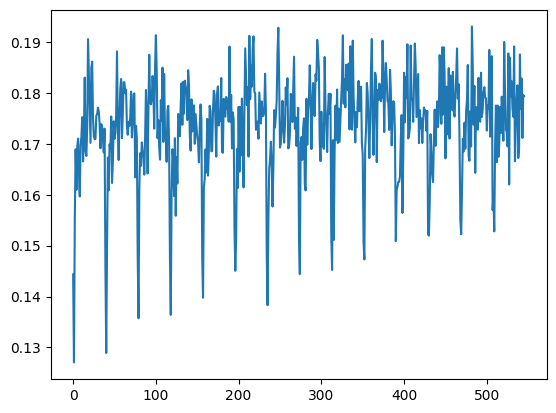

In [17]:
df_groups['return'].plot()

In [18]:
path_csv = '../../../datasharing/df_groups_c.csv'
df_groups.to_csv(path_csv,index = False)
df_groups = pd.read_csv(path_csv)
df_groups.head()

,ex_rate,c,return
0,0.01,0.05,0.144340
1,0.01,0.10,0.127051
2,0.01,0.15,0.155370
3,0.01,0.20,0.168918
4,0.01,0.25,0.160964


In [21]:
fig = px.density_heatmap(df_groups, x="ex_rate", y="c", z="return",
                         histfunc="avg"
                        )
fig.show()

In [26]:
exploration_rate = 0.1
p_c = 1.00

s_final_state = []
for year in tqdm.tqdm(range(2013,2024)):
    st_year = simulate_year(df_2w, [year], n_sims = 5,
                            stock_groups = stock_groups[year],
                            exploration_rate = exploration_rate,
                            p_c = p_c
                           )
    s_final_state.append(st_year)

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  7.11it/s]


In [27]:
df_year = pd.DataFrame(s_final_state)

In [28]:
mean_year = df_year['mean'].mean()
std_year = df_year['mean'].std()
com_ret = (df_year['mean'] + 1).cumprod()
com_ret_last = com_ret.iloc[-1]

Mean average return per year  0.18058997501936852
Mean average std per year  0.1587038841635369
Return final year  5.644756763910612


<AxesSubplot: >

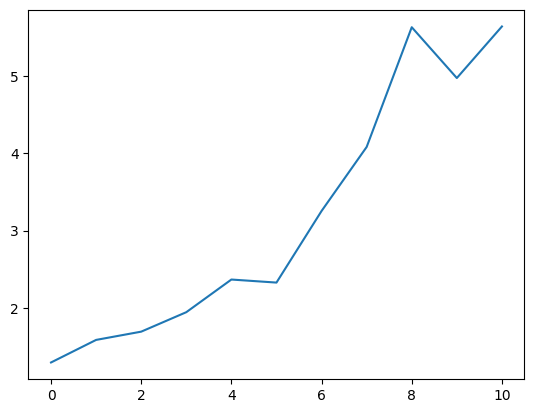

In [29]:
print("Mean average return per year ", mean_year)
print("Mean average std per year ", std_year)
print("Return final year ", com_ret_last)
com_ret.plot()